In [ ]:
! pip install -U sentence-transformers

In [ ]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import load_dataset

ds = load_dataset("PiC/phrase_similarity")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.47k [00:00<?, ?B/s]

phrase_similarity.py:   0%|          | 0.00/4.75k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/1.42M [00:00<?, ?B/s]

PS-hard/validation/0000.parquet:   0%|          | 0.00/202k [00:00<?, ?B/s]

PS-hard/test/0000.parquet:   0%|          | 0.00/403k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7004 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['phrase1', 'phrase2', 'sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 7004
    })
    validation: Dataset({
        features: ['phrase1', 'phrase2', 'sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['phrase1', 'phrase2', 'sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 2000
    })
})

In [ ]:
import torch
from datasets import load_dataset
from sentence_transformers import InputExample, CrossEncoder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available and set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load the PiC/phrase_similarity dataset
dataset = load_dataset("PiC/phrase_similarity")

# Convert the dataset into InputExample format for CrossEncoder
train_samples = [
    InputExample(texts=[item["sentence1"], item["sentence2"]], label=item["label"])
    for item in dataset["train"]
]
val_samples = [
    InputExample(texts=[item["sentence1"], item["sentence2"]], label=item["label"])
    for item in dataset["validation"]
]

# Create DataLoader for the training set
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=64)

# List of models to train
models = [
    "google-bert/bert-large-uncased",
    "FacebookAI/roberta-base",
    "distilbert/distilbert-base-uncased",
    "distilroberta-base"
]

# Initialize lists to store accuracy for plotting
model_names = []
best_accuracies = []
best_epochs = []

# Define a custom evaluation function
def evaluate(model, val_samples):
    val_texts = [sample.texts for sample in val_samples]
    val_labels = [sample.label for sample in val_samples]

    # Predict scores with CrossEncoder
    predictions = model.predict(val_texts)
    predictions = np.argmax(predictions,axis=1)
    predicted_labels = [1 if score >= 0.5 else 0 for score in predictions]  # Convert scores to binary labels

    # Calculate accuracy
    accuracy = accuracy_score(val_labels, predicted_labels)
    return accuracy
num_epochs=10

warmup_steps = int(0.1 * len(train_dataloader) * num_epochs)  # Warm-up steps
learning_rate = 1e-5  # Adjust as needed
model_save_path = "output/crossencoder-pic"
# Loop over the models
all_acc=[]
for model_name in models:
    print(f"Training model: {model_name}")

    # Initialize CrossEncoder with the current model
    model = CrossEncoder(model_name, num_labels=2, device=device)

    # Variables to track the best accuracy and epoch
    best_accuracy = 0
    best_epoch = 0
    accuracies = []

    # Train the model
    for epoch in range(num_epochs):
        model.fit(
            train_dataloader=train_dataloader,
            epochs=1,  # Train for one epoch at a time
            warmup_steps=warmup_steps,
            output_path=model_save_path,
            optimizer_params={"lr": learning_rate}  # Set the learning rate
        )

        # Evaluate after each epoch
        accuracy = evaluate(model, val_samples)
        accuracies.append(accuracy)  # Store accuracy for plotting
        print("Epoch {} Acc {}".format(epoch,accuracy))

        # Save the best model based on accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_epoch = epoch + 1  # Store the epoch (1-indexed)
            model.save(f"{model_save_path}_{model_name.replace('/', '_')}.bin")  # Save the best model
    all_acc.append(accuracies)

#     # Store the results
#     model_names.append(model_name)
#     best_accuracies.append(best_accuracy)
#     best_epochs.append(best_epoch)

#     print(f"Best Model for {model_name} saved with accuracy: {best_accuracy * 100:.2f}% at epoch: {best_epoch}")

# # Plotting the accuracy curves for all models
# plt.figure(figsize=(10, 6))
# for model_name, accuracies in zip(models, accuracies):
#     plt.plot(range(1, num_epochs + 1), accuracies, label=model_name)

# plt.title('Model Accuracy Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid()
# plt.show()

# # Print the best results
# print("\nBest Results:")
# for name, acc, epoch in zip(model_names, best_accuracies, best_epochs):
#     print(f"Model: {name}, Best Accuracy: {acc * 100:.2f}%, Best Epoch: {epoch}")

Using device: cuda
Training model: google-bert/bert-large-uncased


model.safetensors:  68%|######7   | 912M/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 0 Acc 0.504


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 1 Acc 0.504


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 2 Acc 0.634


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 3 Acc 0.687


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 4 Acc 0.67


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 5 Acc 0.685


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 6 Acc 0.667


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 7 Acc 0.692


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 8 Acc 0.691


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 9 Acc 0.698
Training model: FacebookAI/roberta-base


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 0 Acc 0.5


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 1 Acc 0.732


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 2 Acc 0.725


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 3 Acc 0.724


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 4 Acc 0.729


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 5 Acc 0.736


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 6 Acc 0.73


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 7 Acc 0.728


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 8 Acc 0.723


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 9 Acc 0.725
Training model: distilbert/distilbert-base-uncased


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 0 Acc 0.538


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 1 Acc 0.673


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 2 Acc 0.676


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 3 Acc 0.686


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 4 Acc 0.681


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 5 Acc 0.687


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 6 Acc 0.683


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 7 Acc 0.69


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 8 Acc 0.694


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 9 Acc 0.683
Training model: distilroberta-base


config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 0 Acc 0.503


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 1 Acc 0.621


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 2 Acc 0.678


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 3 Acc 0.699


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 4 Acc 0.695


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 5 Acc 0.699


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 6 Acc 0.693


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 7 Acc 0.691


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 8 Acc 0.693


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 9 Acc 0.685


In [13]:
all_acc

[[0.504, 0.504, 0.634, 0.687, 0.67, 0.685, 0.667, 0.692, 0.691, 0.698],
 [0.5, 0.732, 0.725, 0.724, 0.729, 0.736, 0.73, 0.728, 0.723, 0.725],
 [0.538, 0.673, 0.676, 0.686, 0.681, 0.687, 0.683, 0.69, 0.694, 0.683],
 [0.503, 0.621, 0.678, 0.699, 0.695, 0.699, 0.693, 0.691, 0.693, 0.685]]

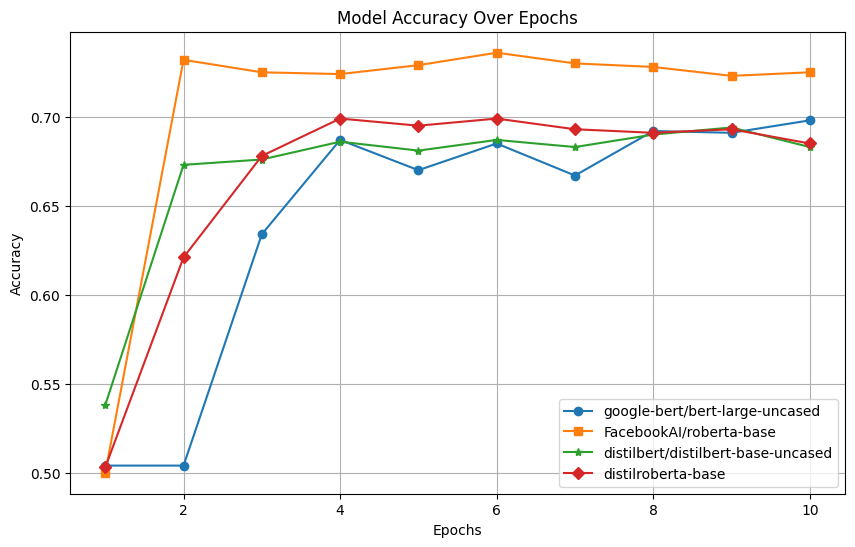

In [2]:
import matplotlib.pyplot as plt

# List of model names
models = [
    "google-bert/bert-large-uncased",
    "FacebookAI/roberta-base",
    "distilbert/distilbert-base-uncased",
    "distilroberta-base"
]

# Accuracy data for each model across 10 epochs
accuracies = [
    [0.504, 0.504, 0.634, 0.687, 0.67, 0.685, 0.667, 0.692, 0.691, 0.698],
    [0.5, 0.732, 0.725, 0.724, 0.729, 0.736, 0.73, 0.728, 0.723, 0.725],
    [0.538, 0.673, 0.676, 0.686, 0.681, 0.687, 0.683, 0.69, 0.694, 0.683],
    [0.503, 0.621, 0.678, 0.699, 0.695, 0.699, 0.693, 0.691, 0.693, 0.685]
]

# Number of epochs
epochs = range(1, 11)  # Assuming 10 epochs

# Markers for each model
markers = ['o', 's', '*', 'D']  # Circle, Square, Star, Diamond markers

# Plotting
plt.figure(figsize=(10, 6))
for model_name, accuracy, marker in zip(models, accuracies, markers):
    plt.plot(epochs, accuracy, marker=marker, label=model_name)

plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()